In [1]:
import jax.numpy as np
from jax import random, grad, jit, partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_fns import NODE_vmap as NN, init_params
import matplotlib.pyplot as plt
import pickle
from NODE_fns import NODE_lm2sigma_vmap
from jax.config import config
config.update("jax_enable_x64", True)

plt.rcParams.update({'font.size': 12})

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
class Alexander():
    def __init__(self, C1=0.1403, C2=0.2542, C3 = 0.0022, kappa = 0.000346, gamma = 5.8088):
        self.C1 = C1
        self.C2 = C2
        self.C3 = C3
        self.kappa = kappa
        self.gamma = gamma
    def Psi1(self, I1):
        C1 = self.C1
        kappa = self.kappa
        return C1*np.exp(kappa*(I1-3)**2)
    def Psi2(self, I2):
        C2 = self.C2
        C3 = self.C3
        gamma = self.gamma
        return C2/(I2-3+gamma) + C3

class NODE():
    def __init__(self, params_I1, params_I2):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
    def Psi1(self, I1):
        return NN(I1-3.0, self.params_I1)
    def Psi2(self, I2):
        return NN(I2-3.0, self.params_I2)

In [3]:
def P11_UT(lamb, model):
    I1 = lamb**2 + 2/lamb
    I2 = 2*lamb + 1/lamb**2
    Psi1 = model.Psi1(I1)
    Psi2 = model.Psi2(I2)
    return 2*(Psi1 + Psi2/lamb)*(lamb-1/lamb**2)
def P11_ET(lamb, model):
    I1 = 2*lamb**2 + 1/lamb**4
    I2 = lamb**4 + 2/lamb**2
    Psi1 = model.Psi1(I1)
    Psi2 = model.Psi2(I2)
    return 2*(Psi1 + Psi2*lamb**2)*(lamb-1/lamb**5)
def P11_PS(lamb, model):
    I1 = I2 = lamb**2 + 1/lamb**2 + 1
    Psi1 = model.Psi1(I1)
    Psi2 = model.Psi2(I2)
    return 2*(Psi1+Psi2)*(lamb-1/lamb**3)

In [4]:
with open('training_data/rubber20UT_ET_PS.npy', 'rb') as f:
    lamb, sigma_gt = np.load(f,allow_pickle=True)
P_gt = sigma_gt/lamb
P11_gt_UT = P_gt[:25,0]
P11_gt_ET = P_gt[25:25+17,0]
P11_gt_PS = P_gt[25+17:,0]
lamb_UT = lamb[:25,0]
lamb_ET = lamb[25:25+17,0]
lamb_PS = lamb[25+17:,0]

model = Alexander()
P11_Ax_UT = P11_UT(lamb_UT, model)
P11_Ax_ET = P11_ET(lamb_ET, model)
P11_Ax_PS = P11_PS(lamb_PS, model)

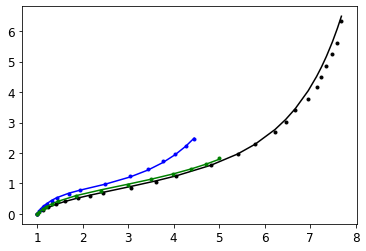

In [5]:
plt.plot(lamb_UT, P11_gt_UT, 'k.')
plt.plot(lamb_UT, P11_Ax_UT, 'k')

plt.plot(lamb_ET, P11_gt_ET, 'b.')
plt.plot(lamb_ET, P11_Ax_ET, 'b')

plt.plot(lamb_PS, P11_gt_PS, 'g.')
plt.plot(lamb_PS, P11_Ax_PS, 'g')

In [6]:
gt_Psi1 = Alexander().Psi1
gt_Psi2 = Alexander().Psi2

@jit
def loss_Psi1(params, I1):
    Psi1_gt = gt_Psi1(I1)
    Psi1_pr = NN(I1-3.0, params)
    return np.mean((Psi1_gt-Psi1_pr)**2)

@jit
def loss_Psi2(params, I2):
    Psi2_gt = gt_Psi2(I2)
    Psi2_pr = NN(I2-3.0, params)
    return np.mean((Psi2_gt-Psi2_pr)**2)

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step(loss, it, opt_state, X)         
        if (it+1)% 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

layers = [2, 5, 5, 1]
params_I1 = init_params(layers, key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_I1)
I1 = np.linspace(3,70)
params_I1, train_loss, val_loss = train(loss_Psi1, I1, opt_state, key, nIter = 50000) #Original 100000

params_I2 = init_params(layers, key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_I2)
I2 = np.linspace(3,500)
params_I2, train_loss, val_loss = train(loss_Psi2, I2, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 1.638268e+01
it 2000, train loss = 6.280226e-01
it 3000, train loss = 8.798833e-02
it 4000, train loss = 2.328872e-02
it 5000, train loss = 8.574869e-03
it 6000, train loss = 4.345756e-03
it 7000, train loss = 2.786720e-03
it 8000, train loss = 1.828315e-03
it 9000, train loss = 1.131877e-03
it 10000, train loss = 6.547558e-04
it 11000, train loss = 3.475913e-04
it 12000, train loss = 1.659163e-04
it 13000, train loss = 7.387104e-05
it 14000, train loss = 3.616090e-05
it 15000, train loss = 2.517094e-05
it 16000, train loss = 2.135135e-05
it 17000, train loss = 8.184499e-06
it 18000, train loss = 5.415740e-06
it 19000, train loss = 4.885865e-06
it 20000, train loss = 4.694619e-06
it 21000, train loss = 4.601415e-06
it 22000, train loss = 4.493401e-06
it 23000, train loss = 4.379991e-06
it 24000, train loss = 4.244776e-06
it 25000, train loss = 4.107488e-06
it 26000, train loss = 3.985617e-06
it 27000, train loss = 3.885150e-06
it 28000, train loss = 3.726415e-06
i

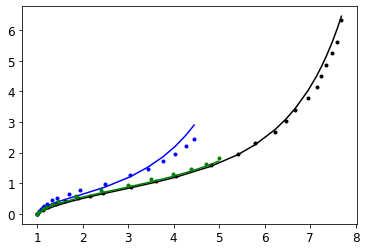

In [7]:
model = NODE(params_I1, params_I2)
P11_NN_UT = P11_UT(lamb_UT, model)
P11_NN_ET = P11_ET(lamb_ET, model)
P11_NN_PS = P11_PS(lamb_PS, model) 

plt.plot(lamb_UT, P11_gt_UT, 'k.')
# plt.plot(lamb_UT, P11_Ax_UT, 'k--')
plt.plot(lamb_UT, P11_NN_UT, 'k')

plt.plot(lamb_ET, P11_gt_ET, 'b.')
# plt.plot(lamb_ET, P11_Ax_ET, 'b--')
plt.plot(lamb_ET, P11_NN_ET, 'b')

plt.plot(lamb_PS, P11_gt_PS, 'g.')
# plt.plot(lamb_PS, P11_Ax_PS, 'g--')
plt.plot(lamb_PS, P11_NN_PS, 'g')

[Text(0.5, 0, '$I_2$'), Text(0, 0.5, '$\\Psi_2$')]

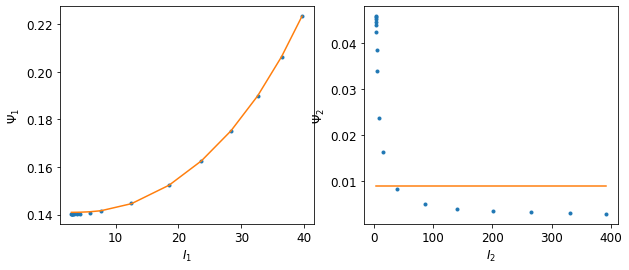

In [17]:
I1 = 2*lamb_ET**2 + 1/lamb_ET**4
I2 = lamb_ET**4 + 2/lamb_ET**2
Psi1_Ax = gt_Psi1(I1)
Psi2_Ax = gt_Psi2(I2)
Psi1_NN = NN(I1-3.0, params_I1)
Psi2_NN = NN(I2-3.0, params_I2)

fig, ax = plt.subplots(1,2, figsize=[10,4])
ax[0].plot(I1, Psi1_Ax, '.')
ax[0].plot(I1, Psi1_NN)
ax[0].set(xlabel='$I_1$', ylabel = '$\Psi_1$')

ax[1].plot(I2, Psi2_Ax, '.')
ax[1].plot(I2, Psi2_NN)
ax[1].set(xlabel='$I_2$', ylabel = '$\Psi_2$')

In [18]:
P11_gt = np.hstack([P11_gt_UT, P11_gt_ET, P11_gt_PS])
P11_Ax = np.hstack([P11_Ax_UT, P11_Ax_ET, P11_Ax_PS])
P11_NN = np.hstack([P11_NN_UT, P11_NN_ET, P11_NN_PS])

MSE_Ax = np.mean((P11_gt-P11_Ax)**2)
MSE_NN = np.mean((P11_gt-P11_NN)**2)
print(MSE_Ax, MSE_NN)

0.015276366097099764 0.02374571394059228
